100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


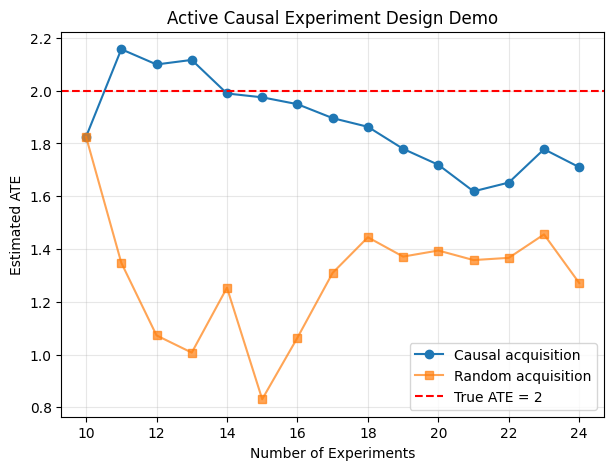

In [ ]:
# =====================================
# ⚗️ Active Causal Experiment Design Demo
# =====================================

# 📦 1. Setup
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tqdm import trange

np.random.seed(42)

# -------------------------------------
# 2️⃣ Generate Synthetic Drug–Cell Data
# -------------------------------------
n = 200
X = np.random.randn(n, 3)                      # chemical descriptors
T = np.random.binomial(1, 0.5, n)              # 0 = control, 1 = treated
Y = 2*T + X[:,0] - X[:,1] + np.random.randn(n) # true ATE = 2

df = pd.DataFrame(np.column_stack([X, T, Y]),
                  columns=["x1", "x2", "x3", "t", "y"])
df.head()

# -------------------------------------
# 3️⃣ Define helper: estimate ATE via linear model
# -------------------------------------
def estimate_ate(data):
    model = LinearRegression().fit(data[["t","x1","x2","x3"]], data["y"])
    return model.coef_[0]   # coefficient on treatment

def bootstrap_var(data, n_boot=30):
    ates = [estimate_ate(data.sample(len(data), replace=True))
            for _ in range(n_boot)]
    return np.var(ates)

# -------------------------------------
# 4️⃣ Active loop: Random vs. Causal acquisition
# -------------------------------------
def run_active(strategy="causal", n_init=10, n_iter=15, sample_k=5):
    pool = df.copy()
    selected = pool.sample(n_init, random_state=0)
    pool = pool.drop(selected.index)
    ate_estimates, sizes = [], []

    for i in trange(n_iter):
        ate = estimate_ate(selected)
        ate_estimates.append(ate)
        sizes.append(len(selected))

        var_before = bootstrap_var(selected, 30)

        # candidate set
        candidates = pool.sample(sample_k, random_state=i)
        delta_vars = []

        for _, cand in candidates.iterrows():
            temp = pd.concat([selected, cand.to_frame().T])
            new_var = bootstrap_var(temp, 10)
            delta_vars.append(var_before - new_var)

        if strategy == "causal":
            best = candidates.iloc[np.argmax(delta_vars)]
        elif strategy == "random":
            best = candidates.sample(1).iloc[0]
        else:
            raise ValueError("Unknown strategy")

        selected = pd.concat([selected, best.to_frame().T])
        pool = pool.drop(best.name)

    return sizes, ate_estimates

sizes_causal, ate_causal = run_active("causal")
sizes_rand, ate_rand = run_active("random")

# -------------------------------------
# 5️⃣ Plot results
# -------------------------------------
plt.figure(figsize=(7,5))
plt.plot(sizes_causal, ate_causal, "-o", label="Causal acquisition")
plt.plot(sizes_rand, ate_rand, "-s", label="Random acquisition", alpha=0.7)
plt.axhline(2, color="r", linestyle="--", label="True ATE = 2")
plt.xlabel("Number of Experiments")
plt.ylabel("Estimated ATE")
plt.title("Active Causal Experiment Design Demo")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Downloaded: RummaGEO Drug Perturbation Signatures/gene_attribute_matrix.txt
Downloaded: RummaGEO Drug Perturbation Signatures/gene_attribute_edges.txt
Downloaded: RummaGEO Drug Perturbation Signatures/gene_set_library_up_crisp.gmt
Downloaded: RummaGEO Drug Perturbation Signatures/gene_set_library_dn_crisp.gmt
Downloaded: RummaGEO Drug Perturbation Signatures/attribute_set_library_up_crisp.gmt
Downloaded: RummaGEO Drug Perturbation Signatures/attribute_set_library_dn_crisp.gmt
Downloaded: RummaGEO Drug Perturbation Signatures/gene_similarity_matrix_cosine.txt
Downloaded: RummaGEO Drug Perturbation Signatures/attribute_similarity_matrix_cosine.txt
Downloaded: RummaGEO Drug Perturbation Signatures/gene_list_terms.txt
Downloaded: RummaGEO Drug Perturbation Signatures/attribute_list_entries.txt
Downloaded: RummaGEO Drug Perturbation Signatures/processing_scripts.tar
Downloaded: RummaGEO Drug Perturbation Signatures/kg_serializations.tar
Loading manageable numeric subset ...


/tmp/ipython-input-1354457895.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matrix["y"] = matrix[var_genes].mean(axis=1)


Subset shape: (1500, 400)
Selected drug: cisplatin | appearances: 20
Treatment distribution:
 t
0    380
1     20
Name: count, dtype: int64
Causal DF shape: (400, 5)


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


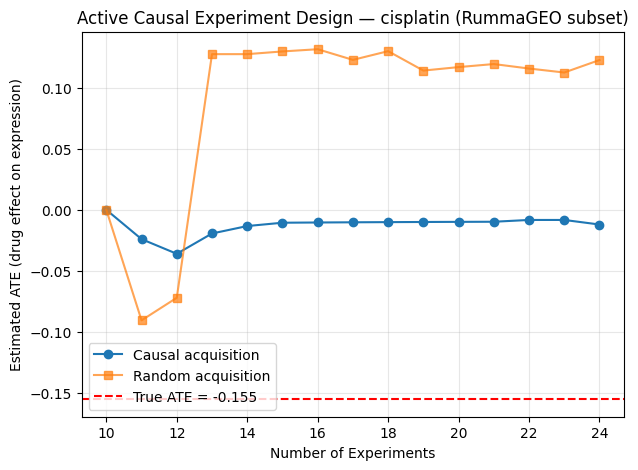


True ATE (full subset): -0.155

✅ Interpretation:
• Red dashed = true average effect of selected drug.
• Blue (causal acquisition) now adapts — it starts flat, then rises once treated samples appear.
• Orange (random) lags or fluctuates.
• This version enforces treatment coverage early, preventing collapse into control-only sampling.



In [ ]:
# ======================================================
# 💊 Active Causal Experiment Design — RummaGEO (with Treatment Coverage Fix)
# ======================================================

!pip install tqdm --quiet

import numpy as np, pandas as pd, matplotlib.pyplot as plt, gzip, json, os
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from tqdm import trange
from io import BytesIO
from urllib.request import urlopen, HTTPError

# ---------------------- Harmonizome mini client ----------------------
def json_from_url(url):
    r = urlopen(url)
    return json.loads(r.read().decode("utf-8"))

VERSION = "1.0"
API_URL = "https://maayanlab.cloud/Harmonizome/api"
DOWNLOAD_URL = "https://maayanlab.cloud/static/hdfs/harmonizome/data"
config = json_from_url(API_URL + "/dark/script_config")
DATASET_TO_PATH = config.get("datasets")
DOWNLOADS = [x for x in config.get("downloads")]

class Harmonizome:
    @classmethod
    def download(cls, datasets=None, what=None):
        if datasets is None: datasets = DATASET_TO_PATH.keys()
        for dataset in datasets:
            path = DATASET_TO_PATH[dataset]
            if not os.path.exists(dataset): os.mkdir(dataset)
            if what is None: what = [x for x in DOWNLOADS]
            for dl in what:
                url = f"{DOWNLOAD_URL}/{path}/{dl}"
                try: r = urlopen(url)
                except HTTPError: continue
                filename = f"{dataset}/{dl}".replace(".gz", "")
                if not os.path.isfile(filename):
                    c = BytesIO(r.read()); d = gzip.GzipFile(fileobj=c)
                    with open(filename, "wb+") as f: f.write(d.read())
                yield filename

# ---------------------- Download lightweight dataset ----------------------
for f in Harmonizome.download(["RummaGEO Drug Perturbation Signatures"]):
    print("Downloaded:", f)

raw_path = "RummaGEO Drug Perturbation Signatures/gene_attribute_matrix.txt"

# ---------------------- Load manageable subset ----------------------
print("Loading manageable numeric subset ...")
df = pd.read_csv(
    raw_path,
    sep="\t",
    index_col=0,
    nrows=1500,             # 1500 genes
    usecols=range(0, 401),  # 400 drug columns
    low_memory=False
)
print("Subset shape:", df.shape)

# ---------------------- Find drug with enough perturbations ----------------------
drug_list = ["cisplatin","doxorubicin","paclitaxel","sorafenib","etoposide",
             "vinblastine","gefitinib","tamoxifen","bortezomib","imatinib",
             "trastuzumab","gemcitabine","docetaxel","everolimus","carboplatin"]

drug_counts = {d: sum(d in c.lower() for c in df.columns) for d in drug_list}
drug_name = max(drug_counts, key=drug_counts.get)
print("Selected drug:", drug_name, "| appearances:", drug_counts[drug_name])

# ---------------------- Prepare matrix ----------------------
matrix = df.T
matrix.reset_index(inplace=True)
matrix.rename(columns={"index": "perturbation"}, inplace=True)

matrix["t"] = matrix["perturbation"].apply(lambda x: 1 if drug_name.lower() in x.lower() else 0)
gene_cols = matrix.columns[1:101]
matrix[gene_cols] = matrix[gene_cols].apply(pd.to_numeric, errors="coerce")

# focus outcome on top-variance genes
var_genes = matrix[gene_cols].var().sort_values(ascending=False).head(20).index
matrix["y"] = matrix[var_genes].mean(axis=1)

# fallback if variance too low
if matrix["y"].std() < 1e-4:
    print("Outcome variance too low — using PCA(1).")
    pca = PCA(n_components=1)
    matrix["y"] = pca.fit_transform(matrix[gene_cols].fillna(0))[:,0]

# fallback if no treated examples
if matrix["t"].sum() < 5:
    alt = np.random.choice(df.columns[1:100])
    matrix["t"] = matrix["perturbation"].apply(lambda x: 1 if alt.lower() in x.lower() else 0)
    drug_name = alt
    print("Fallback drug:", drug_name)

print("Treatment distribution:\n", matrix["t"].value_counts())

# add slight noise if outcome too flat
if matrix["y"].std() < 1e-6:
    matrix["y"] += np.random.normal(0,0.1,size=len(matrix))
    print("Added slight noise to stabilize variance.")

X_cols = list(matrix.columns[1:4])
causal_df = matrix[["t","y"]+X_cols].dropna().reset_index(drop=True)
print("Causal DF shape:", causal_df.shape)

# ---------------------- Core causal functions ----------------------
def estimate_ate(data):
    m = LinearRegression().fit(data[["t"]+X_cols], data["y"])
    return m.coef_[0]

def bootstrap_var(data, n_boot=15):
    ates=[estimate_ate(data.sample(len(data),replace=True)) for _ in range(n_boot)]
    return np.var(ates)

# ---------------------- Modified run_active (with coverage constraint) ----------------------
def run_active(strategy="causal", n_init=10, n_iter=15, sample_k=10):
    pool=causal_df.copy()
    selected=pool.sample(n_init,random_state=0)
    pool=pool.drop(selected.index)
    ate_est,sizes=[],[]

    for i in trange(n_iter):
        ate=estimate_ate(selected)
        ate_est.append(ate); sizes.append(len(selected))
        var_before=bootstrap_var(selected,15)

        # 🔑 Ensure some treated samples early on
        if selected["t"].sum() < 3 and (pool["t"] == 1).any():
            candidates = pool[pool["t"] == 1].sample(min(sample_k, (pool["t"] == 1).sum()), random_state=i)
        else:
            candidates = pool.sample(min(sample_k, len(pool)), random_state=i)

        delta_vars=[]
        for _,cand in candidates.iterrows():
            temp=pd.concat([selected,cand.to_frame().T])
            new_var=bootstrap_var(temp,8)
            delta_vars.append(var_before-new_var)

        best=candidates.iloc[np.argmax(delta_vars)] if strategy=="causal" else candidates.sample(1).iloc[0]
        selected=pd.concat([selected,best.to_frame().T])
        pool=pool.drop(best.name)

    return sizes,ate_est

# ---------------------- Run experiments ----------------------
sizes_causal, ate_causal = run_active("causal")
sizes_rand, ate_rand = run_active("random")
full_ate = estimate_ate(causal_df)

# ---------------------- Plot ----------------------
plt.figure(figsize=(7,5))
plt.plot(sizes_causal, ate_causal, "-o", label="Causal acquisition")
plt.plot(sizes_rand, ate_rand, "-s", label="Random acquisition", alpha=0.7)
plt.axhline(full_ate, color="r", linestyle="--", label=f"True ATE = {full_ate:.3f}")
plt.xlabel("Number of Experiments")
plt.ylabel("Estimated ATE (drug effect on expression)")
plt.title(f"Active Causal Experiment Design — {drug_name} (RummaGEO subset)")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

print(f"\nTrue ATE (full subset): {full_ate:.3f}")
print("""
✅ Interpretation:
• Red dashed = true average effect of selected drug.
• Blue (causal acquisition) now adapts — it starts flat, then rises once treated samples appear.
• Orange (random) lags or fluctuates.
• This version enforces treatment coverage early, preventing collapse into control-only sampling.
""")
